<a href="https://colab.research.google.com/github/Lenzeg/thesis_notebook/blob/main/t2_thesis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Iterative Feature Analysis in Insomnia with High-Risk for Depression: Exploring Treatment Effect on Self-Rated Depression**
<small>Jupyter notebook for research master thesis Cognitive Neuropsychology by Lennart Zegerius</small>

---


In this notebook I collect variables from both questionnaires and physiological data to use in a model that predicts depression progression after I-Sleep treatment.

This thesis contains the code which can be used to replicate the thesis' results, intermediate output and comments, and also serves as a supplementary material for:

* Collected Feature Description
* Results of Feature Selection
* Principal Component Loadings & Scree Plot 
* Correlation Matrix of Fesulting Feature Set
* Bayesian Optimization Result
* Removed Features

Also, this code can be run to export sets of .csv or .xlsx files, containing resulting simple regressions for all features, correlation matrix for all features, and the final dataset pre-analysis.


**Data:**

* 115 Subjects
* 221 Features 


**Dependencies:**

*Upon request. This github is currently public as the thesis is being graded. For privacy reasons, nothing is uploaded to the public github*

* csd.csv
* actigraphy.csv
* ECG.csv
* ISI.xlsx
* IDS.xlsx
* eeg.csv
* fmri_task_rs.xlsx
* screener.xlsx
* fmri_emo_xlsx
* dmri_fa.csv
* mctqc.xlsx
---





### **Libraries**

In [ ]:
%%capture

# Uncomment first run
!pip install ptitprince
!pip install plotly
!pip install bayesian-optimization
!pip install eli5
!pip install shap
!pip install pdpbox


# Basic
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.collections as clt
import ptitprince as pt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Preprocessing 
from sklearn.feature_selection import SelectKBest, f_regression, chi2, mutual_info_regression, r_regression, RFECV 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# Eval & Feature importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, get_dataset, info_plots
from scipy import stats

# Data Processing

### **Import Variables from Questionnaires**


In [ ]:
#--------------------------------------------------------------------------------------------------
# Import CSV's

ecg = pd.read_csv('ECG.csv', sep=";", usecols=['subject', 'HR_sleep', 'HR_wake','HR_24','HFnu_wake','HFnu_sleep','HFnu_24','Sdnn_wake','Sdnn_24','Rmssd_wake','Rmssd_sleep','Rmssd_24','Drop.out'])
ids = pd.read_excel('IDS.xlsx', usecols=['subject', 'Male', 'Age', 'TimePoint', 'IDSSR_score','IDSSR_score_no_sleep','therapy_condition','risk','Drop.out'])
isi = pd.read_excel('ISI.xlsx', usecols=['subject', 'TimePoint', 'ISI_score', 'ISI_0001a_PP','ISI_0001b_PP','ISI_0001c_PP','insomnia_subtype_true', 'Drop.out'])
screener = pd.read_excel('screener.xlsx', usecols=['subject', 'SCRN_ITQ_ACS_score','SCRN_ITQ_BAS_score','SCRN_ITQ_SHS_score', 'SCRN_ITQ_RPA_positive_rumination','SCRN_ITQ_RPA_dampening','SCRN_ITQ_RRS_score','SCRN_ITQ_MIPIP_extraversion','SCRN_ITQ_MIPIP_neuroticism','SCRN_ITQ_MIPIP_agreeableness','SCRN_ITQ_PANAS_negative_affect','SCRN_ITQ_PANAS_positive_affect','SCRN_ITQ_TEPS_score','SCRN_ITQ_PI_organization','SCRN_ITQ_PI_perceived_parental_pressure','SCRN_ITQ_PI_rumination','SCRN_ITQ_PI_score_R','SCRN_ITQ_FIRST_score','SCRN_ITQ_PSAS_score','SCRN_ITQ_FSS_score','SCRN_ITQ_CTQ_score', 'Drop.out'])
actigraphy = pd.read_csv('actigraphy.csv', usecols=['subject', 'Drop.out', 'TimePoint','TST_TIB','TIB','SE_TIB','SOW','TST_SOW','Awakenings_TIB','Mean_Temp','Bedtime_Dec_Hr', 'EyesClosed_Dec_Hr','SleepOpEnd_Dec_Hr','Getuptime_Dec_Hr','Mid-Sleep_Time_Dec_Hr','Cr_of_Grav_Temp_Dec_Hr','Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr'])
sleep = pd.read_csv('eeg.csv')
csd = pd.read_csv('csd.csv', usecols=['subject','TimePoint','CSDM_TIB_Recalc','CSDM_SOW_Recalc','CSDM_TST_Recalc','CSDM_SEtib_Recalc','CSDM_SEsow_Recalc','CSD_Bedtime_Dec_Hr', 'CSD_EyesClosed_Dec_Hr','CSD_SleepOpEnd_Dec_Hr','CSD_SOL_min','CSD_LogSOL+1','CSD_WASO_num','CSD_logWASO_num+1','CSD_WASO_min','CSD_logWASO_min+1','CSD_EMA_min','logCSD_EMA_min+1','CSD_Getuptime_Dec_Hr','CSD_Mid-Sleep_Time_Dec_Hr','CSD_Qualit','CSD_WellRested','CSD_BedtimeSleepiness','CSD_OvernightSleepinessChange','CSD_Bedtime_Worry','CSD_Thoughts','CSD_Dreams','CSD_Thoughts-Dreams','CSD_Nap'])
fmri_rs = pd.read_excel('fmri_task_rs.xlsx',usecols=['subject','TimePoint','vis_som','vis_dors','vis_vent','vis_limb','vis_fp','vis_def','som_dors','som_vent','som_limb','som_fp','som_def','dors_vent','dors_limb','dors_fp','dors_def','vent_limb','vent_fp','vent_def','limb_fp','limb_def','fp_def'])
fmri_emo = pd.read_excel('fmri_emo.xlsx',usecols=['subject','TimePoint','Z_AmygdalaL_nvoxels','Z_AmygdalaL_min','Z_AmygdalaL_mean','Z_AmygdalaL_median','Z_AmygdalaL_max','Z_AmygdalaR_nvoxels','Z_AmygdalaR_min','Z_AmygdalaR_mean','Z_AmygdalaR_median','Z_AmygdalaR_max'])
dmri_fa = pd.read_csv('dmri_fa.csv',usecols=['subject',"mean_skel","no_label_skel","Middle_cerebellar_peduncle","Pontine_crossing_tract_(a_part_of_MCP)","Genu_of_corpus_callosum","Body_of_corpus_callosum","Splenium_of_corpus_callosum","Fornix_(column_and_body_of_fornix)","Corticospinal_tract_R","Corticospinal_tract_L","Medial_lemniscus_R","Medial_lemniscus_L","Inferior_cerebellar_peduncle_R__","Inferior_cerebellar_peduncle_L","Superior_cerebellar_peduncle_R","Superior_cerebellar_peduncle_L","Cerebral_peduncle_R","Cerebral_peduncle_L","Anterior_limb_of_internal_capsule_R","Anterior_limb_of_internal_capsule_L","Posterior_limb_of_internal_capsule_R","Posterior_limb_of_internal_capsule_L","Retrolenticular_part_of_internal_capsule_R","Retrolenticular_part_of_internal_capsule_L","Anterior_corona_radiata_R","Anterior_corona_radiata_L","Superior_corona_radiata_R","Superior_corona_radiata_L","Posterior_corona_radiata_R","Posterior_corona_radiata_L","Posterior_thalamic_radiation_(include_optic_radiation)_R","Posterior_thalamic_radiation_(include_optic_radiation)_L","Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_R","Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_L","External_capsule_R","External_capsule_L","Cingulum_(cingulate_gyrus)_R","Cingulum_(cingulate_gyrus)_L","Cingulum_(hippocampus)_R","Cingulum_(hippocampus)_L","Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_R","Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_L","Superior_longitudinal_fasciculus_R","Superior_longitudinal_fasciculus_L","Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_R","Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_L","Uncinate_fasciculus_R","Uncinate_fasciculus_L","Tapetum_R","Tapetum_L"])
mctq = pd.read_excel('mctqc.xlsx', usecols=['subject','MCTQC_sleepDurationWork_PP_hr','MCTQC_sleepDurationFree_PP_hr','MidSleepCorrected_dec_hr'])


#--------------------------------------------------------------------------------------------------
# some processing before continuing

ids = ids.drop(ids[ids['Drop.out'] == 1].index)                       # dropping all dropouts
ids = ids.drop(ids[ids['therapy_condition'] == 5].index)              # 5 is not a treatment group
isi = isi.drop(isi[isi['Drop.out'] == 1].index)                       
ecg = ecg.drop(ecg[ecg['Drop.out'] == 1].index)
actigraphy = actigraphy.drop(actigraphy[actigraphy['Drop.out'] == 1].index)
screener = screener.drop(screener[screener['Drop.out'] == 1].index)             


#--------------------------------------------------------------------------------------------------
# using mean of all recorded days for ecg features. 

ecg_grouped = ecg[['subject','HR_sleep','HR_wake','HR_24','HFnu_wake','HFnu_sleep','HFnu_24','Sdnn_wake','Sdnn_24','Rmssd_wake','Rmssd_sleep','Rmssd_24',]].groupby(['subject']).mean().reset_index()   


#--------------------------------------------------------------------------------------------------
# Preprocessing fmri features

fmri_rs = fmri_rs.loc[(fmri_rs['TimePoint'] == 'T0')].add_prefix('T0_').rename(columns={'T0_subject':'subject','T0_TimePoint':'TimePoint'}).drop('TimePoint',axis=1)
fmri_emo = fmri_emo.loc[(fmri_emo['TimePoint'] == 'T0')].add_prefix('T0_').rename(columns={'T0_subject':'subject','T0_TimePoint':'TimePoint'}).drop('TimePoint',axis=1)


#--------------------------------------------------------------------------------------------------
# processing actigraphy features. std & mean for T0 and T1, group & rename.

act_mean_grouped = actigraphy[['subject','TimePoint','TST_TIB','TIB','SE_TIB','SOW','TST_SOW','Awakenings_TIB','Mean_Temp','Bedtime_Dec_Hr', 'EyesClosed_Dec_Hr','SleepOpEnd_Dec_Hr','Getuptime_Dec_Hr','Mid-Sleep_Time_Dec_Hr','Cr_of_Grav_Temp_Dec_Hr','Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr']].groupby(['subject', 'TimePoint']).mean().reset_index()   # using mean of all recorded days per timepoint
act_mean_T0 = act_mean_grouped.loc[(act_mean_grouped['TimePoint'] == 'T0')].add_prefix('T0_mean_').rename(columns={'T0_mean_subject':'subject','T0_mean_TimePoint':'TimePoint'})
act_mean_T1 = act_mean_grouped.loc[(act_mean_grouped['TimePoint'] == 'T1')].add_prefix('T1_mean_').rename(columns={'T1_mean_subject':'subject','T1_mean_TimePoint':'TimePoint'})

act_sd_grouped = actigraphy[['subject','TimePoint','TST_TIB','TIB','SE_TIB','SOW','TST_SOW','Awakenings_TIB','Mean_Temp','Bedtime_Dec_Hr', 'EyesClosed_Dec_Hr','SleepOpEnd_Dec_Hr','Getuptime_Dec_Hr','Mid-Sleep_Time_Dec_Hr','Cr_of_Grav_Temp_Dec_Hr','Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr']].groupby(['subject', 'TimePoint']).std().reset_index()  # using std of all recording days per timepoint
act_sd_T0 = act_sd_grouped.loc[(act_sd_grouped['TimePoint'] == 'T0')].add_prefix('T0_sd_').rename(columns={'T0_sd_subject':'subject','T0_sd_TimePoint':'TimePoint'})
act_sd_T1 = act_sd_grouped.loc[(act_sd_grouped['TimePoint'] == 'T1')].add_prefix('T1_sd_').rename(columns={'T1_sd_subject':'subject','T1_sd_TimePoint':'TimePoint'})

# processing csd features. std & mean for T0 and T1, group & rename.
csd_sd_grouped = csd[['subject','TimePoint','CSDM_TIB_Recalc','CSDM_SOW_Recalc','CSDM_TST_Recalc','CSDM_SEtib_Recalc','CSDM_SEsow_Recalc','CSD_Bedtime_Dec_Hr', 'CSD_EyesClosed_Dec_Hr','CSD_SleepOpEnd_Dec_Hr','CSD_SOL_min','CSD_LogSOL+1','CSD_WASO_num','CSD_logWASO_num+1','CSD_WASO_min','CSD_logWASO_min+1','CSD_EMA_min','logCSD_EMA_min+1','CSD_Getuptime_Dec_Hr','CSD_Mid-Sleep_Time_Dec_Hr','CSD_Qualit','CSD_WellRested','CSD_BedtimeSleepiness','CSD_OvernightSleepinessChange','CSD_Bedtime_Worry','CSD_Thoughts','CSD_Dreams','CSD_Thoughts-Dreams','CSD_Nap']].groupby(['subject', 'TimePoint']).std().reset_index()  # using std of all recording days per timepoint
csd_sd_T0 = csd_sd_grouped.loc[(csd_sd_grouped['TimePoint'] == 'T0')].add_prefix('T0_sd_').rename(columns={'T0_sd_subject':'subject','T0_sd_TimePoint':'TimePoint'})
csd_sd_T1 = csd_sd_grouped.loc[(csd_sd_grouped['TimePoint'] == 'T1')].add_prefix('T1_sd_').rename(columns={'T1_sd_subject':'subject','T1_sd_TimePoint':'TimePoint'})

csd_mean_grouped = csd[['subject','TimePoint','CSDM_TIB_Recalc','CSDM_SOW_Recalc','CSDM_TST_Recalc','CSDM_SEtib_Recalc','CSDM_SEsow_Recalc','CSD_Bedtime_Dec_Hr', 'CSD_EyesClosed_Dec_Hr','CSD_SleepOpEnd_Dec_Hr','CSD_SOL_min','CSD_LogSOL+1','CSD_WASO_num','CSD_logWASO_num+1','CSD_WASO_min','CSD_logWASO_min+1','CSD_EMA_min','logCSD_EMA_min+1','CSD_Getuptime_Dec_Hr','CSD_Mid-Sleep_Time_Dec_Hr','CSD_Qualit','CSD_WellRested','CSD_BedtimeSleepiness','CSD_OvernightSleepinessChange','CSD_Bedtime_Worry','CSD_Thoughts','CSD_Dreams','CSD_Thoughts-Dreams','CSD_Nap']].groupby(['subject', 'TimePoint']).mean().reset_index()  # using std of all recording days per timepoint
csd_mean_T0 = csd_mean_grouped.loc[(csd_mean_grouped['TimePoint'] == 'T0')].add_prefix('T0_mean_').rename(columns={'T0_mean_subject':'subject','T0_mean_TimePoint':'TimePoint'})
csd_mean_T1 = csd_mean_grouped.loc[(csd_mean_grouped['TimePoint'] == 'T1')].add_prefix('T1_mean_').rename(columns={'T1_mean_subject':'subject','T1_mean_TimePoint':'TimePoint'})

#--------------------------------------------------------------------------------------------------
# delete remaining columns that are not needed anymore
del act_mean_T0['TimePoint'], act_mean_T1['TimePoint'], act_sd_T0['TimePoint'], act_sd_T1['TimePoint'], csd_mean_T0['TimePoint'], csd_mean_T1['TimePoint'], csd_sd_T0['TimePoint'], csd_sd_T1['TimePoint']
del sleep['Subj_Time']
del screener['Drop.out']

### Explanation of Features

**Inventory of Depression Symptomatology (IDSSR) & Insomnia Subtype Questionnaire (ISI)**

| Feature | Description
| --- | --- |
| T0_IDSSR | Total Score of IDS at T0 |
| T1_IDSSR | Total Score of IDS at T1 |
| T0_ISI | Total Score of ISI at T0 |


**Insomnia Type Questionnaire (ITQ)** 

| Abbreviation | Description
| --- | --- |
| ACS | Action Control Scale |
| BAS | Behavioural System and Activation System Scale |
| SHS | Subjective Happiness Scale |
| RPAS | Response to Positive Affect |
| RRS | Ruminative Response Scale |
| MINI-IPIP | Mini International Personality Item Pool |
| PANAS | Positive and Negative Affect Scale |
| TEPS | Temporal Experience of Pleasure |
| PI | Perfectionism Inventory |
| FIRST | Ford Insomnia Response to Stress Test |
| PSAS | Pre-sleep Arousal Scale |
| FSS | Fatigue Severity Scale |
| ISI | Insomnia Severity Index |
| CTQ | Childhood Trauma Questionnaire |


**Insomnia Subtypes**

| Subtype | Description 
| --- | --- |
| 0 | Control |
| 1 | Highly Distressed |
| 2 | Moderately Distressed + Reward Sensitive |
| 3 | Moderately Distressed - Reward Sensitive |
| 4 | Low Distress + Highly Reactive |
| 5 | Low Distress + Low Reactive |



**Munich Chronotype Questionnaire (MCTQ)**

| Feature | Description 
| --- | --- |
| MCTQC_sleepDurationWork_PP_hr | Midpoint between sleep on- and offset on work days |
| MCTQC_sleepDurationFree_PP_hr | Midpoint between sleep on- and offset on free days |
| MidSleepCorrected_dec_hr | Midpoint between sleep on- and offset |


**Actigraphy (ACT)**
*Both Standard Deviation (SD) & Mean*

| Feature | Meaning 
| --- | --- |
| TIB | Time In Bed |
| TST | Total Sleep Time |
| SE | Sleep Efficiency |
| SO | Sleep Onset |
| WASO | Wake After Sleep Onset |
| SOW | Sleep Opportunity Window |
| Mean_Temp | Mean night temperature |
| Bedtime_Dec_Hr | Bedtime in decimals |
| EyesClosed_Dec_Hr | Subjective eyes closed moment in decimals |
| SleepOpEnd_Dec_Hr | Sleep opportunity ending in decimals |
| Getuptime_Dec_Hr | Get up time in decimals |
| Mid-sleep_time_dec_hr | Sleep onset + half of total sleep time in decimals |
| Mean_Temp_Cr_of_Grav_Dec_Hr | Decimal Time point in the night where the center of gravity of the temperature is |
| Cr_of_grav_to_Mid_sleep_delay_Dec_Hr | Center of gravity in relation to mid sleep delay in decimals |


**Consensus Sleep Diary (CSD)**
*Both Standard Deviation (SD) & Mean*

| Name | Meaning 
| --- | --- |
| CSDM_TIB_Recalc | a somewhat-24 hour decimal value of time in bed |
| CSDM_SOW_Recalc | ^ but sleep opportunity window |
| CSDM_TST_Recalc | ^ but total sleep time |
| CSDM_SEtib_Recalc | ^ but sleep efficiency during time in bed |
| CSDM_SEsow_Recalc | ^ but sleep efficiency during sleep opportunity window |
| CSD_Bedtime_Dec_Hr | Bedtime in decimals |
| CSD_EyesClosed_Dec_Her | Time Decimal of remembered closing of eyes |
| CSD_SleepOpEnd_Dec_Hr | Time Decimal when the sleep opportunity ended |
| CSD_SOL_min | Time Decimal of sleep onset latency in minutes |
| CSD_LogSOL+1 | Time Decimal of sleep onset latency but the logtransform to remove skewing |
| CSD_WASO_num | Number of wakeful moments after sleep onset |
| CSD_logWASO_num+1 | Log because skewed |
| CSD_WASO_min | Total time of wakeful moments (in minutes) |
| CSD_EMA_min | Early Morning Awakenings (in minutes) |
| logCSD_EMA_min+1 | Log because skewed |
| CSD_Getuptime_Dec_Hr | Time Decimal of Estimated Get Up Time  |
| CSD_Mid-Sleep_Time_Dec_Hr | Sleep Onset Dec Hr + Half of total assumed sleep time |
| CSD_Qualit | How would you rate your sleep? (0-4) |
| CSD_WellRested | How well rested are you after sleep? (0-4) |
| CSD_BedtimeSleepiness | How sleepy were you when you went to bed? (0-4) |
| CSD_OvernightSleepinessChange | Bedtime sleepiness - Well Rested score |
| CSD_Bedtime_Worry | Were you worrying before going to bed? (0-4) |
| CSD_Thoughts | Were you thinking during sleep? (0-4) |
| CDS_Dreams | Were you dreaming during sleep? (0-4) |
| CSD_Thoughts-Dreams | Thinking mnius dreaming |
| CSD_Nap | Did you take naps during the day? (0-6) |

**Task Based Emo Functional Magnetic Resonance Imaging (fMRI)**

| Name | Meaning 
| --- | --- |
| Z_AmygdalaL_nvoxels	| nr of voxels of left amygdala mask | 
| Z_AmygdalaL_min	| minimum Z value within left amygdala mask | 
| Z_AmygdalaL_mean |	average Z value across all voxels of left amygdala mask | 
| Z_AmygdalaL_median |	median Z value across all voxels of left amygdala mask | 
| Z_AmygdalaL_max	| maximum Z value within left amygdala mask | 
| Z_AmygdalaR_nvoxels	| nr of voxels of right amygdala mask | 
| Z_AmygdalaR_min |	minimum Z value within right amygdala mask | 
| Z_AmygdalaR_mean |	average Z value across all voxels of right amygdala mask | 
| Z_AmygdalaR_median |	median Z value across all voxels of right amygdala mask | 
| Z_AmygdalaR_max	| maximum Z value within right amygdala mask | 

**Resting State fMRI**

Yeo Networks: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3174820/

| Legend for Yeo networks |
| --- | 
| (purple) - visual |
| (blue)   - somatomotor  |
| (green)  - dorsal attention |
| (violet) - ventral attention |
| (cream)  - limbic |
| (orange) - frontoparietal |
| (red)    - default |


**Diffusion Tensor Imaging (DTI)**

| Name |
| --- |
| Middle_cerebellar_peduncle |
| Pontine_crossing_tract_(a_part_of_MCP) |
| Genu_of_corpus_callosum |
| Body_of_corpus_callosum |
| Splenium_of_corpus_callosum |
| Fornix_(column_and_body_of_fornix) |
| Corticospinal_tract_R |
| Corticospinal_tract_L |
| Medial_lemniscus_R |
| Medial_lemniscus_L |
| Inferior_cerebellar_peduncle_R  |
| Inferior_cerebellar_peduncle_L |
| Superior_cerebellar_peduncle_R |
| Superior_cerebellar_peduncle_L |
| Cerebral_peduncle_R  |
| Cerebral_peduncle_L |
| Anterior_limb_of_internal_capsule_R |
| Anterior_limb_of_internal_capsule_L |
| Posterior_limb_of_internal_capsule_R |
| Posterior_limb_of_internal_capsule_L |
| Retrolenticular_part_of_internal_capsule_R |
| Retrolenticular_part_of_internal_capsule_L |
| Anterior_corona_radiata_R |
| Anterior_corona_radiata_L |
| Superior_corona_radiata_R |
| Superior_corona_radiata_L |
| Posterior_corona_radiata_R |
| Posterior_corona_radiata_L |
| Posterior_thalamic_radiation_(include_optic_radiation)_R |
| Posterior_thalamic_radiation_(include_optic_radiation)_L |
| Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_R |
| Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_L |
| External_capsule_R |
| External_capsule_L |
| Cingulum_(cingulate_gyrus)_R |
| Cingulum_(cingulate_gyrus)_L |
| Cingulum_(hippocampus)_R |
| Cingulum_(hippocampus)_L |
| Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_R |
| Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_L |
| Superior_longitudinal_fasciculus_R |
| Superior_longitudinal_fasciculus_L |
| Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_R |
| Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_L |
| Uncinate_fasciculus_R |
| Uncinate_fasciculus_L |
| Tapetum_R |
| Tapetum_L |

**High Definition Electroencephalography (HD-EEG)**

| Feature | Meaning 
| --- | --- |
| sleep_period_dur | Total sleep period duration |
| N1_perc | Percentage of N1 sleep |
| N2_perc | Percentage of N2 sleep |
| N3_perc | Percentage of N3 sleep |
| R_perc | Percentage Of REM Sleep |
| WASO_perc | Percentage of wakeful moments after aleep onset |
| N2_delay | Time of sleep onset until N2 sleep |
| N3_delay | Time of sleep onset until N3 sleep |
| R_delay | Time of sleep onset until REM sleep |
| stage_change_dens | Number of stage changes / total sleep period  |
| NR_frag_dens | Fragmentation density during Non-REM sleep |
| NRasc_frag_dens | Fragmentation density during Non-REM ascension sleep (from deeper to light sleep) |
| R_frag_dens | Fragmentation density during REM sleep |



**Electrocardiogram (ECG)**
*Measured during the EEG night*

| Feature | Meaning 
| --- | --- |
| HR_wake | Average heart rate awake |
| HR_sleep | Average heart rate asleep |
| HR_24 | Average heart rate during the day |
| HFnu_wake | Average heart frequency awake in normal units|
| HFnu_sleep | Average heart frequency asleep in normal units |
| HFnu_24 | Average heart frequency during the day in normal units |
| SDnn_wake | Standard deviation of normal sinus beats awake|
| SDnn_sleep | Standard deviation of normal sinus beats asleep |
| SDnn_24 | Standard deviation of normal sinus beats during the day |
| Rmssd_wake | The root mean square of successive differences between normal heartbeats awake |
| Rmssd_sleep | The root mean square of successive differences between normal heartbeats asleep |
| Rmssd_24 | The root mean square of successive differences between normal heartbeats during the day |


### **Initial Data Processing**

* Merging
* Conditionals
* Dummy coding

In [ ]:
#--------------------------------------------------------------------------------------------------
# Init
columns = ['subject','Male', 'Age']
df = pd.DataFrame(columns=columns)
df_agg = pd.DataFrame()




# Build dataframe using subject, male and age. Drop duplicates. 
df['subject'] = ids['subject'].drop_duplicates()
df['Male'] = ids['Male']
df['Age'] = ids['Age']
df['therapy_condition'] = ids['therapy_condition']
df['risk'] = ids['risk']
df['insomnia_subtype'] = isi['insomnia_subtype_true']

#--------------------------------------------------------------------------------------------------
# Temporary dataframe to aggregate values from multiple rows in the csv.

df_agg['subject'] = ids['subject']
df_agg['T0_IDSSR'] = ids.loc[ids['TimePoint'] == 'T0','IDSSR_score']
# df_agg['T1_IDSSR'] = ids.loc[ids['TimePoint'] == 'T1','IDSSR_score']
df_agg['T2_IDSSR'] = ids.loc[ids['TimePoint'] == 'T2','IDSSR_score']
# df_agg['T3_IDSSR'] = ids.loc[ids['TimePoint'] == 'T3','IDSSR_score']
# df_agg['T4_IDSSR'] = ids.loc[ids['TimePoint'] == 'T4','IDSSR_score']

df_agg['T0_ISI'] = isi.loc[isi['TimePoint'] == 'T0','ISI_score']
# df_agg['T1_ISI'] = isi.loc[isi['TimePoint'] == 'T1','ISI_score']
# df_agg['T2_ISI'] = isi.loc[isi['TimePoint'] == 'T2','ISI_score']
# df_agg['T3_ISI'] = isi.loc[isi['TimePoint'] == 'T3','ISI_score']
# df_agg['T4_ISI'] = isi.loc[isi['TimePoint'] == 'T4','ISI_score']

df_agg['T0_DIS'] = isi.loc[isi['TimePoint'] == 'T0','ISI_0001a_PP'] # DIFFICULTY INITIATING SLEEP
df_agg['T0_DMA'] = isi.loc[isi['TimePoint'] == 'T0','ISI_0001b_PP'] # DIFFICULTY STAYING ASLEEP
df_agg['T0_EMA'] = isi.loc[isi['TimePoint'] == 'T0','ISI_0001c_PP'] # EARLY MORNING AWAKENINGS

# df_agg['T1_DIS'] = isi.loc[isi['TimePoint'] == 'T1','ISI_0001a_PP']
# df_agg['T1_DMA'] = isi.loc[isi['TimePoint'] == 'T1','ISI_0001b_PP']
# df_agg['T1_EMA'] = isi.loc[isi['TimePoint'] == 'T1','ISI_0001c_PP']

# df_agg['T2_DIS'] = isi.loc[isi['TimePoint'] == 'T2','ISI_0001a_PP']
# df_agg['T2_DMA'] = isi.loc[isi['TimePoint'] == 'T2','ISI_0001b_PP']
# df_agg['T2_EMA'] = isi.loc[isi['TimePoint'] == 'T2','ISI_0001c_PP']

# df_agg['T3_DIS'] = isi.loc[isi['TimePoint'] == 'T3','ISI_0001a_PP']
# df_agg['T3_DMA'] = isi.loc[isi['TimePoint'] == 'T3','ISI_0001b_PP']
# df_agg['T3_EMA'] = isi.loc[isi['TimePoint'] == 'T3','ISI_0001c_PP']

# df_agg['T4_DIS'] = isi.loc[isi['TimePoint'] == 'T4','ISI_0001a_PP']
# df_agg['T4_DMA'] = isi.loc[isi['TimePoint'] == 'T4','ISI_0001b_PP']
# df_agg['T4_EMA'] = isi.loc[isi['TimePoint'] == 'T4','ISI_0001c_PP']


# df_agg = df_agg.groupby(df_agg['subject']).aggregate({'T0_IDSSR': 'sum','T1_IDSSR': 'sum','T2_IDSSR': 'sum','T3_IDSSR':'sum','T4_IDSSR': 'sum','T0_ISI': 'sum','T1_ISI': 'sum','T2_ISI': 'sum','T3_ISI': 'sum','T4_ISI': 'sum','T0_DIS': 'sum','T0_DMA': 'sum','T0_EMA': 'sum','T1_DIS': 'sum','T1_DMA': 'sum','T1_EMA': 'sum','T2_DIS': 'sum','T2_DMA': 'sum','T2_EMA': 'sum','T3_DIS': 'sum','T3_DMA': 'sum','T3_EMA': 'sum','T4_DIS': 'sum','T4_DMA': 'sum','T4_EMA': 'sum',})
df_agg = df_agg.groupby(df_agg['subject']).aggregate({'T0_IDSSR': 'sum','T0_ISI': 'sum','T0_DIS': 'sum','T0_DMA': 'sum','T0_EMA': 'sum','T0_IDSSR': 'sum','T2_IDSSR':'sum'})

#--------------------------------------------------------------------------------------------------
# Add aggregations to the main dataframe
df = df.merge(df_agg,on='subject')
df = df.merge(ecg_grouped,on='subject')
df = df.merge(act_mean_T0, on='subject', how='left')
df = df.merge(act_sd_T0, on='subject', how='left')
df = df.merge(act_mean_T1, on='subject', how='left')
df = df.merge(act_sd_T1, on='subject', how='left')
df = df.merge(screener, on='subject', how='left')
df = df.merge(csd_mean_T0, on='subject',how='left')
df = df.merge(csd_sd_T0, on='subject',how='left')
df = df.merge(csd_mean_T1, on='subject',how='left')
df = df.merge(csd_sd_T1, on='subject',how='left')
df = df.merge(sleep, on='subject',how='left')
df.reset_index(drop=True, inplace=True)

# Process column names
df['therapy_condition'].loc[(df['therapy_condition'] == 0)] = 'control'
df['therapy_condition'].loc[(df['therapy_condition'] == 1)] = 'cbti'
df['therapy_condition'].loc[(df['therapy_condition'] == 2)] = 'ct'
df['therapy_condition'].loc[(df['therapy_condition'] == 3)] = 'cbti_ct'
df['therapy_condition'].loc[(df['therapy_condition'] == 4)] = 'tau'
df.rename(columns={'therapy_condition':'therapy'}, inplace=True)
df['risk'].loc[(df['risk'] == 'high_risk')] = 'high'
df['risk'].loc[(df['risk'] == 'low_risk')] = 'low'

#--------------------------------------------------------------------------------------------------
# Encode categorical variables
df_no_dums = df.copy()
df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=['risk', 'therapy','insomnia_subtype'])

# Exclude controls, comment next line to include
df = df[df.therapy_control != 1]
df = df[df.risk_low != 1]

print(df.shape)

display(df.columns)


(115, 231)


Index(['subject', 'Male', 'Age', 'T0_IDSSR', 'T0_ISI', 'T0_DIS', 'T0_DMA',
       'T0_EMA', 'T2_IDSSR', 'HR_sleep',
       ...
       'therapy_cbti_ct', 'therapy_control', 'therapy_ct', 'therapy_tau',
       'insomnia_subtype_0', 'insomnia_subtype_1', 'insomnia_subtype_2',
       'insomnia_subtype_3', 'insomnia_subtype_4', 'insomnia_subtype_5'],
      dtype='object', length=231)

### **Building Domain Dataframes**





In [ ]:
#--------------------------------------------------------------------------------------------------
# Gather therapy values, both dummified and not
therapy = df[list(df.filter(regex='therapy_cbti|therapy_cbti_ct|therapy_ct|subject|subtype'))]
therapy_condition = df_no_dums[list(df_no_dums.filter(regex='therapy|subject'))]

#--------------------------------------------------------------------------------------------------
# Process Domains

# 1. All_T0
df_T0 = df[df.columns.drop(list(df.filter(regex='T1|T2|T3|T4')))]

# 2. Questionnaires_T0
q_T0 = df_T0[df_T0.columns.drop(sleep.columns)]
q_T0 = q_T0[q_T0.columns.drop(ecg_grouped.columns, errors='ignore')]
q_T0 = q_T0[q_T0.columns.drop(act_mean_T0.columns,  errors='ignore')]
q_T0 = q_T0[q_T0.columns.drop(act_sd_T0.columns,  errors='ignore')]

# 3. ITQ 
itq_T0 = q_T0[q_T0.columns.drop(csd_mean_T0.columns,  errors='ignore')]
itq_T0 = itq_T0[itq_T0.columns.drop(csd_sd_T0.columns,  errors='ignore')]
itq_T0 = itq_T0[itq_T0.columns.drop(q_T0[['T0_ISI','T0_IDSSR']])]

# 4. CSD_T0
csd_T0 = q_T0[q_T0.columns.drop(screener.columns,  errors='ignore')]
csd_T0 = csd_T0[csd_T0.columns.drop(q_T0[['T0_ISI','T0_IDSSR']])]

# 5. Actigraphy 
act_T0 = df_T0[df_T0.columns.drop(sleep.columns)]
act_T0 = act_T0[act_T0.columns.drop(ecg_grouped.columns, errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(csd_mean_T0.columns,  errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(csd_sd_T0.columns,  errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(screener.columns,  errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(act_T0[['T0_ISI','T0_IDSSR']])]

# 6. HD-EEG 
sleep_T0 = df_T0[sleep.columns]

# 7. ECG 
ecg_T0 = df[ecg_grouped.columns]

# 8,9. Full DTI and fMRI
dmri_T0 = dmri_fa.copy()
fmri_T0 = fmri_emo.merge(fmri_rs, on='subject')

#--------------------------------------------------------------------------------------------------
# Drop Male and Age (added later in baseline column section)
q_T0 = q_T0.drop(['Male','Age'],axis=1)
itq_T0 = itq_T0.drop(['Male','Age'],axis=1)
csd_T0 = csd_T0.drop(['Male','Age'],axis=1)
act_T0 = act_T0.drop(['Male','Age'],axis=1)

#--------------------------------------------------------------------------------------------------
# Merging Therapy
sleep_T0 = sleep_T0.merge(therapy, on='subject')
ecg_T0 = ecg_T0.merge(therapy, on='subject')
fmri_T0 = fmri_T0.merge(therapy,on='subject')
dmri_T0 = dmri_T0.merge(therapy,on='subject')



#--------------------------------------------------------------------------------------------------
# Completing the matrix, missing 7 rows. Rows are imputed.
empty_rows = 6
for i in range(0, empty_rows):
    fmri_T0 = fmri_T0.append(pd.Series(), ignore_index=True)

dmri_T0[:] = KNNImputer().fit_transform(dmri_T0)
fmri_T0[:] = KNNImputer().fit_transform(fmri_T0)



#--------------------------------------------------------------------------------------------------
# Post Name-Processing (for R scripts to work)
df_T0.columns = df_T0.columns.str.replace("+", "_and_")
df_T0.columns = df_T0.columns.str.replace(" ", "")
df_T0.columns = df_T0.columns.str.replace("-", "_")

df_T0_nodums = df_T0.copy()
df_T0_nodums = df_T0_nodums.merge(therapy_condition)
df_T0 = df_T0.merge(therapy) # do this after the no_dums version

q_T0.columns = q_T0.columns.str.replace("+", "_and_")
q_T0.columns = q_T0.columns.str.replace(" ", "")
q_T0.columns = q_T0.columns.str.replace("-", "_")

itq_T0.columns = itq_T0.columns.str.replace("+", "_and_")
itq_T0.columns = itq_T0.columns.str.replace(" ", "")
itq_T0.columns = itq_T0.columns.str.replace("-", "_")

csd_T0.columns = csd_T0.columns.str.replace("+", "_and_")
csd_T0.columns = csd_T0.columns.str.replace(" ", "")
csd_T0.columns = csd_T0.columns.str.replace("-", "_")

act_T0.columns = act_T0.columns.str.replace("+", "_and_")
act_T0.columns = act_T0.columns.str.replace(" ", "")
act_T0.columns = act_T0.columns.str.replace("-", "_")

sleep_T0.columns = sleep_T0.columns.str.replace("+", "_and_")
sleep_T0.columns = sleep_T0.columns.str.replace(" ", "")
sleep_T0.columns = sleep_T0.columns.str.replace("-", "_")

ecg_T0.columns = ecg_T0.columns.str.replace("+", "_and_")
ecg_T0.columns = ecg_T0.columns.str.replace(" ", "")
ecg_T0.columns = ecg_T0.columns.str.replace("-", "_")

#--------------------------------------------------------------------------------------------------

# Drop dummies, apparently they still got in!
df_T0 =df_T0[df_T0.columns.drop(list(df_T0.filter(regex='control|subtype|tau|subtype|risk')))]
act_T0 = act_T0[act_T0.columns.drop(list(act_T0.filter(regex='control|subtype|tau|subtype|risk')))]
csd_T0 = csd_T0[csd_T0.columns.drop(list(csd_T0.filter(regex='control|subtype|tau|subtype|risk')))]
itq_T0 = itq_T0[itq_T0.columns.drop(list(itq_T0.filter(regex='control|subtype|tau|subtype|risk')))]


# For descriptive analyses
frames = [itq_T0,csd_T0,act_T0,sleep_T0,ecg_T0,dmri_T0,fmri_T0,df_T0]
for frame in frames:
    conditions=[((frame['therapy_cbti'] == 0) & (frame['therapy_cbti_ct'] == 1)),((frame['therapy_cbti'] == 1) & (frame['therapy_cbti_ct'] == 0)),((frame['therapy_cbti'] == 0) & (frame['therapy_cbti_ct'] == 0))]
    values = ['cbti_ct','cbti','other']
    frame['therapy'] = np.select(conditions, values)

#--------------------------------------------------------------------------------------------------
# Baseline and target columns
baseline = ['T0_ISI', 'Male', 'Age']
target = df[['subject','T2_IDSSR']]

#--------------------------------------------------------------------------------------------------
# Add Target

df_T0 = df_T0.merge(target)
df_T0 = df_T0.merge(fmri_T0, how='left')
df_T0 = df_T0.merge(dmri_T0, how='left')

df_T0 =df_T0[df_T0.columns.drop(list(df_T0.filter(regex='control|subtype|tau|subtype|risk')))]


#--------------------------------------------------------------------------------------------------
# Delete section. Undo if 'subject' is needed 
# del df_T0['subject']
# del scaled_df_T0['subject']
del df_T0_nodums['subject']
del sleep_T0['subject']
del ecg_T0['subject']
del fmri_T0['subject']
del dmri_T0['subject']


#--------------------------------------------------------------------------------------------------
# Misc fixes
dmri_T0 =dmri_T0[dmri_T0.columns.drop(list(dmri_T0.filter(regex='control|subtype|tau|subtype|risk|therapy')))]
sleep_T0 =sleep_T0[sleep_T0.columns.drop(list(sleep_T0.filter(regex='control|subtype|tau|subtype|risk')))]

df_T0_nodums =df_T0_nodums[df_T0_nodums.columns.drop(list(df_T0_nodums.filter(regex='cbti|control|ct|subtype|tau|risk')))]


# Add MCTQ as a comparative variable for skin temperature. 
df_T0 = df_T0.merge(mctq, on='subject')

# FINAL EXPORT OF DATAFRAME USED FOR ANALYSIS. NOTE: ALSO CONTAINS SUBJECT & T1 IDS-SR: REMOVE DURING ANALYSES. 
df_T0.to_csv('df_pre_analysis.csv')

# 223 features - this is including subject and T1 IDSSR, so 221 after removal.
print(f"Observations: {df_T0.shape[0]}\nFeatures: {df_T0.shape[1]}")



Observations: 115
Features: 223


# Feature Selection

###**Running Principal Component Analysis**

Explained variation PCA_all: [0.09814902 0.06830789 0.06365577 0.04453952 0.04362434 0.03465043
 0.03172085 0.02917888 0.02752819 0.02413782 0.02294698 0.0209913
 0.02018602 0.01951626]
Cumulative sum R2: [ 9.8 16.6 23.  27.5 31.9 35.4 38.6 41.5 44.3 46.7 49.  51.1 53.1 55.1]


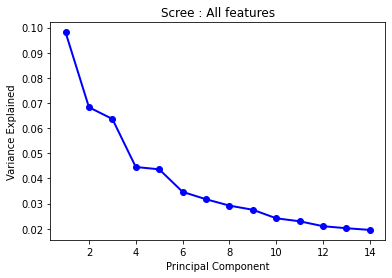

 FROM 223 FEATURES TO 14 FEATURES


In [ ]:
scaler = StandardScaler()

# # Initialize dataframe
pca_df = pd.DataFrame(columns=[])
pca_df_all = pd.DataFrame(columns=[])

# --------- Build PCA's for ALL T0 DATA and append to dataframe -----------

# SCALING
extra_cols = ['therapy']
copied_df_T0 = df_T0.copy().drop(extra_cols,axis=1)
copied_df_T0[:] = KNNImputer().fit_transform(copied_df_T0)

df_st =  StandardScaler().fit_transform(copied_df_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_df_T0.columns, index=copied_df_T0.index)
scaled_df_T0.merge(fmri_T0)


# PCA
pca_all = scaled_df_T0
pca = PCA(n_components=14)
pca_result = pca.fit_transform(pca_all)
for i in range(0,pca.n_components_):
  pca_df_all[f'PCA_{i}'] = pca_result[:,i]
print('Explained variation PCA_all: {}'.format(pca.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree : All features')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print('=====================\n FROM {} FEATURES TO {} FEATURES\n======================'.format(len(df_T0.columns),len(pca_df_all.columns)))



pca_components = pca.components_.T
pca_r2 = pca.explained_variance_
pca_r2_ratio = pca.explained_variance_ratio_
components = pca_result




#### PCA Loadings
`Loadings = eigenvectors \ sqrt(eigenvalues)`

The matrix below shows the loadings of the PCA.
Each entry of the matrix contains the **correlation between the original variable and the principal component**. For example, 




In [ ]:
#--------------------------------------------------------------------------------------------------
# CALCULATE LOADINGS, BASIC VERSION THAT SORTS BY PCA_0

loadings = pca_components * np.sqrt(pca_r2)

columns = [column for column in pca_df_all.columns]

loadings = pd.DataFrame(
    loadings.round(2),
    columns=columns,
    index=pca_all.columns,
).abs()

loadings.index.name = "Variables"
loadings = loadings.sort_values(by=['PCA_0'],ascending=False)

#--------------------------------------------------------------------------------------------------

# MAKE A DICTIONARY OF ALL LOADINGS PER PCA. THIS IS TO SORT THEM AND CALCULATE SMALLEST AND LARGEST
pca_dict = {}
pca_largest_dict = {}
pca_smallest_dict = {}
pca_collection = []
for i in range(0,loadings.columns.size):
    data_pca = pd.DataFrame(loadings[f'PCA_{i}']).sort_values(by=[f'PCA_{i}'],ascending=False)
    data_pca.index.name = 'Variables'
    pca_dict["pca_" + str(i)] = data_pca.reset_index()
    pca_largest_dict["pca_" + str(i)] = pca_dict[f"pca_{i}"].nlargest(n=5, columns=[f'PCA_{i}'])
    pca_smallest_dict["pca_" + str(i)] = pca_dict[f"pca_{i}"].nsmallest(n=5, columns=[f'PCA_{i}'])
    pca_collection.append(pca_largest_dict[f'pca_{i}']['Variables'][0])

for i in range(0,pca_r2_ratio.size):
    print(f'==== EXPLAINED VARIANCE OF PCA {i} ====')
    print(pca_r2_ratio[i])
    display(pca_dict[f'pca_{i}'].head(5))
    print('\n')



#--------------------------------------------------------------------------------------------------

# CONCATENATE ALL VARIABLES TO ASSESS WHICH VARIABLES OCCUR MOST.
concat_vars = pd.DataFrame()
for key in pca_largest_dict.keys():
    concat_vars = pd.concat([concat_vars, pca_largest_dict[f'{key}']['Variables']])

# EXTRACT TOP n OCCURRING VARIABLES
subset = concat_vars[0].value_counts().to_frame()
subset = subset[:10].index.values.tolist()
df_occurences = df_T0[subset]

#--------------------------------------------------------------------------------------------------

# SUM ALL VARIABLES TOTAL CONTRIBUTION. note: look for negatives as well.
complete_pca = loadings.copy().reset_index()
complete_pca.insert(0, 'sum', complete_pca.sum(axis=1) )
largest_sum = complete_pca.nlargest(n=14, columns=['sum'])
largest_vars = largest_sum['Variables'].tolist()

### Note: Loadings are basically how similar some factors are in a certain principal component. If a variable has a high loading, it correlates well with other variables in that component.
### High loading variables are not copies of eachother, but have their own unique relationship with other variables. 
### The idea is to take the top loadings per PC and add them to the feature set.

==== EXPLAINED VARIANCE OF PCA 0 ====
0.09814901599038904


,Variables,PCA_0
0,mean_skel,0.90
1,no_label_skel,0.84
2,Sagittal_stratum_(include_inferior_longitidina...,0.77
3,Genu_of_corpus_callosum,0.73
4,Anterior_corona_radiata_R,0.73




==== EXPLAINED VARIANCE OF PCA 1 ====
0.06830788580551173


,Variables,PCA_1
0,T0_mean_Mid_Sleep_Time_Dec_Hr,0.69
1,T0_mean_CSD_Mid_Sleep_Time_Dec_Hr,0.69
2,T0_mean_CSD_EyesClosed_Dec_Hr,0.66
3,T0_mean_EyesClosed_Dec_Hr,0.66
4,T0_vis_limb,0.62




==== EXPLAINED VARIANCE OF PCA 2 ====
0.06365577150716778


,Variables,PCA_2
0,T0_som_def,0.63
1,T0_vent_def,0.61
2,T0_vent_limb,0.58
3,T0_som_vent,0.57
4,T0_som_fp,0.56




==== EXPLAINED VARIANCE OF PCA 3 ====
0.044539515095990405


,Variables,PCA_3
0,T0_mean_CSDM_SOW_Recalc,0.67
1,T0_mean_SOW,0.67
2,T0_mean_TIB,0.62
3,T0_mean_CSDM_TIB_Recalc,0.59
4,T0_mean_SleepOpEnd_Dec_Hr,0.58




==== EXPLAINED VARIANCE OF PCA 4 ====
0.04362434357882493


,Variables,PCA_4
0,T0_mean_CSDM_TST_Recalc,0.85
1,T0_mean_CSDM_SEsow_Recalc,0.70
2,T0_mean_CSDM_SEtib_Recalc,0.66
3,MCTQC_sleepDurationFree_PP_hr,0.65
4,T0_sd_CSDM_SEsow_Recalc,0.63




==== EXPLAINED VARIANCE OF PCA 5 ====
0.03465042509097789


,Variables,PCA_5
0,T0_Z_AmygdalaL_mean,0.58
1,T0_Z_AmygdalaL_median,0.58
2,T0_Z_AmygdalaL_max,0.51
3,T0_Z_AmygdalaR_median,0.47
4,T0_Z_AmygdalaR_mean,0.47




==== EXPLAINED VARIANCE OF PCA 6 ====
0.03172085032509971


,Variables,PCA_6
0,SCRN_ITQ_ACS_score,0.46
1,Sdnn_24,0.38
2,N3_perc,0.37
3,T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,0.37
4,Sdnn_wake,0.37




==== EXPLAINED VARIANCE OF PCA 7 ====
0.02917887658163596


,Variables,PCA_7
0,Superior_cerebellar_peduncle_L,0.59
1,Superior_cerebellar_peduncle_R,0.53
2,T0_mean_Bedtime_Dec_Hr,0.43
3,T0_mean_CSD_BedtimeSleepiness,0.42
4,T0_mean_CSD_Bedtime_Dec_Hr,0.39




==== EXPLAINED VARIANCE OF PCA 8 ====
0.027528189222462213


,Variables,PCA_8
0,HFnu_24,0.48
1,T0_sd_CSD_LogSOL_and_1,0.48
2,T0_sd_CSD_SOL_min,0.47
3,T0_sd_CSD_Qualit,0.44
4,HFnu_wake,0.42




==== EXPLAINED VARIANCE OF PCA 9 ====
0.02413782474833519


,Variables,PCA_9
0,Male,0.50
1,T0_Z_AmygdalaR_median,0.47
2,T0_Z_AmygdalaR_mean,0.46
3,SCRN_ITQ_PI_score_R,0.44
4,SCRN_ITQ_PI_perceived_parental_pressure,0.40




==== EXPLAINED VARIANCE OF PCA 10 ====
0.022946981581806598


,Variables,PCA_10
0,SCRN_ITQ_RRS_score,0.46
1,HFnu_24,0.38
2,HFnu_sleep,0.37
3,SCRN_ITQ_PI_rumination,0.37
4,SCRN_ITQ_PI_score_R,0.35




==== EXPLAINED VARIANCE OF PCA 11 ====
0.0209912957786817


,Variables,PCA_11
0,T0_sd_CSD_Thoughts,0.44
1,Middle_cerebellar_peduncle,0.44
2,T0_sd_CSD_Bedtime_Worry,0.42
3,T0_sd_CSD_Thoughts_Dreams,0.38
4,T0_mean_CSD_Thoughts,0.34




==== EXPLAINED VARIANCE OF PCA 12 ====
0.020186019961168238


,Variables,PCA_12
0,T0_sd_CSD_WellRested,0.39
1,T0_ISI,0.38
2,T0_sd_CSD_OvernightSleepinessChange,0.36
3,T0_sd_logCSD_EMA_min_and_1,0.33
4,subject,0.33




==== EXPLAINED VARIANCE OF PCA 13 ====
0.01951626115885527


,Variables,PCA_13
0,HR_24,0.47
1,HR_wake,0.45
2,HR_sleep,0.39
3,Age,0.37
4,T0_mean_CSD_logWASO_num_and_1,0.36


## **Feature Ranking: SelectKBest**


In [ ]:
#--------------------------------------------------------------------------------------------------
# IMPUTE VALUES 

X_kbest = df_T0.copy().drop(['subject','therapy'],axis=1)
y_kbest = X_kbest.pop('T2_IDSSR')
X_kbest[:] = KNNImputer().fit_transform(X_kbest)
X_kbest_mif = X_kbest.copy()


#--------------------------------------------------------------------------------------------------
# F_REGRESSION

select = SelectKBest(score_func= f_regression, k=14)
z = select.fit(X_kbest,y_kbest)
mask = select.get_support()
new_features = X_kbest.columns[mask]

f_df = pd.DataFrame(index = new_features, columns=['F_statistic','P_value'])
f_df['F_statistic'] = z.scores_[mask].round(2)
f_df['P_value'] = z.pvalues_[mask].round(3)
display(f_df)

filter = select.get_support()
features = X_kbest.columns
 
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)

f_features = features[filter]

#--------------------------------------------------------------------------------------------------
# MUTUAL_INFO_REGRESSION

select = SelectKBest(score_func= mutual_info_regression, k=14)
z = select.fit(X_kbest_mif,y_kbest)
mask = select.get_support()
new_features = X_kbest_mif.columns[mask]


mif_df = pd.DataFrame(index = new_features)

mif_df['Mutual Information'] = z.scores_[mask].round(2)
display(mif_df)



filter = select.get_support()
features = X_kbest_mif.columns
 
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)

mif_features = features[filter]

#NOTE: Due to a lack of random_seed in the SelectKBest version of Mutual Info Regression and F_regression, the features of one run are fixed here.
# Multiple runs only change slightly and influence results slightly, but for reporting, a single run is decided. 
# To those who want to experiment with this code, feel free to run it and see changes and its effect on the explained variance or final feature set. It only differs slightly and does not impact interpretation.
# mif_features = ['T0_IDSSR','HFnu_wake','T0_mean_EyesClosed_Dec_Hr','SCRN_ITQ_MIPIP_neuroticism','SCRN_ITQ_PANAS_negative_affect','SCRN_ITQ_FSS_score','T0_Z_AmygdalaL_nvoxels','T0_Z_AmygdalaL_min','Superior_cerebellar_peduncle_R','Superior_cerebellar_peduncle_L','Retrolenticular_part_of_internal_capsule_L','Posterior_thalamic_radiation_(include_optic_radiation)_L','Uncinate_fasciculus_L','MCTQC_sleepDurationFree_PP_hr']
# f_features = ['T0_IDSSR', 'T0_ISI', 'T0_mean_EyesClosed_Dec_Hr',
    #    'T0_sd_Getuptime_Dec_Hr', 'T0_sd_Cr_of_Grav_Temp_Dec_Hr',
    #    'SCRN_ITQ_SHS_score', 'SCRN_ITQ_RRS_score',
    #    'SCRN_ITQ_MIPIP_neuroticism', 'SCRN_ITQ_PANAS_negative_affect',
    #    'SCRN_ITQ_FSS_score', 'therapy_cbti', 'Superior_cerebellar_peduncle_L',
    #    'Uncinate_fasciculus_R', 'Uncinate_fasciculus_L']

,F_statistic,P_value
Male,6.05,0.015
T0_IDSSR,24.54,0.000
T0_mean_EyesClosed_Dec_Hr,5.42,0.022
T0_sd_TST_TIB,4.43,0.038
T0_sd_TST_SOW,4.30,0.040
SCRN_ITQ_SHS_score,12.07,0.001
SCRN_ITQ_RRS_score,9.43,0.003
SCRN_ITQ_MIPIP_neuroticism,10.15,0.002
SCRN_ITQ_PANAS_negative_affect,4.64,0.033
SCRN_ITQ_FSS_score,6.28,0.014


,Mutual Information
HR_wake,0.11
HFnu_wake,0.16
T0_sd_Awakenings_TIB,0.24
SCRN_ITQ_RRS_score,0.16
T0_mean_CSD_Mid_Sleep_Time_Dec_Hr,0.10
T0_sd_CSD_logWASO_num_and_1,0.14
N1_perc,0.10
T0_Z_AmygdalaR_max,0.12
Superior_corona_radiata_R,0.17
Posterior_thalamic_radiation_(include_optic_radiation)_R,0.24


## **Recursive Feature Elimination with Cross-Validation (RFECV)**

In [ ]:
# Re-copy and impute initial data for reusability. 
X = df_T0.copy().drop(['subject','therapy'],axis=1)
y = X.pop('T2_IDSSR')
X[:] = KNNImputer().fit_transform(X_kbest)

# Build RFE module
regressor = XGBRegressor(objective = 'reg:squarederror')
feature_selector = RFECV(regressor, step=1, min_features_to_select=14,cv=4, scoring='explained_variance')
fit = feature_selector.fit(X,y)
rfecv_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])
columns = X.columns[feature_selector.support_]

for i in range(X.shape[1]):
    row = {'feature': X.columns[i], 'support': feature_selector.support_[i], 'ranking': feature_selector.ranking_[i]}
    rfecv_features = rfecv_features.append(row, ignore_index=True)
    
# Print best features. Note: ranking is 1 for many features due to the large input set!
rfecv_features = rfecv_features.sort_values(by='ranking')[:21]
rfecv_features = rfecv_features[rfecv_features['support']==True].reset_index(drop=True)
display(rfecv_features)




,feature,support,ranking
0,R_delay,True,1
1,T0_sd_CSD_Mid_Sleep_Time_Dec_Hr,True,1
2,T0_Z_AmygdalaR_mean,True,1
3,SCRN_ITQ_MIPIP_neuroticism,True,1
4,SCRN_ITQ_RRS_score,True,1
5,SCRN_ITQ_RPA_dampening,True,1
6,T0_Z_AmygdalaR_min,True,1
7,SCRN_ITQ_SHS_score,True,1
8,SCRN_ITQ_BAS_score,True,1
9,T0_dors_limb,True,1


## **Construct Feature List For XGBoost**

In [ ]:
# Intersect findings into first feature iteration set

mif_f_intersection = set(list(mif_features)).intersection(set(list(f_features)))
rfecv_f_intersection = set(list(rfecv_features['feature'])).intersection(set(list(f_features)))
rfecv_mif_intersection = set(list(rfecv_features['feature'])).intersection(set(list(mif_features)))
features_iteration_one = list(set(list(rfecv_features['feature']) + list(mif_features) + list(f_features)))

### MANUAL STEP #######
### BUILD FINAL FEATURE SET BY ADDING AND SUBTRACTING FROM THE VARIABLE feature_set. 
### ASSESS WHAT XGBOOST FOUND IMPORTANT, REMOVE UNDERPERFORMERS. COMPARE TO PCA'S.
### GOAL: FEATURE SET CAN BE LARGER THAN ADVISED, AS LONG AS FEATURES ARE NOT REDUNDANT. 
### RETAIN ONLY THE BEST FEATURES, AND COLLECT THE BEST FEATURES ITERATIVELY.

# ITERATION ONE
print("ITERATION ONE. \nFEATURES AFTER FEATURE SELECTION.")
print(features_iteration_one)
print("NUMBER OF FEATURES: ")
print(len(features_iteration_one))

to_remove_one = ['N1_perc','T0_sd_CSD_logWASO_num_and_1','SCRN_ITQ_BAS_score','External_capsule_L','T0_sd_Awakenings_TIB','SCRN_ITQ_PI_score_R','SCRN_ITQ_PI_organization','HFnu_wake','T0_dors_limb','Male','Superior_corona_radiata_R']
features_iteration_two = list(set(features_iteration_one) - set(to_remove_one))

# ITERATION TWO
print("\nITERATION TWO.")
print("REMOVED: ")
print(to_remove_one)
print(len(to_remove_one))
print("\nFEATURES AFTER REDUCING IN ITERATION ONE:")
print(features_iteration_two)

print("FEATURES LEFT: ")
print(len(features_iteration_two))

to_remove_two = ['Cingulum_(cingulate_gyrus)_R','T0_sd_Mid_Sleep_Time_Dec_Hr','HR_wake','Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_R','T0_sd_CSDM_TIB_Recalc','T0_sd_Mid_Sleep_Time_Dec_Hr','Cingulum_(cingulate_gyrus)_R']
features_iteration_three = list(set(features_iteration_two) - set(to_remove_two))

to_remove_three = ['Uncinate_fasciculus_L','T0_sd_CSD_Bedtime_Worry','T0_Z_AmygdalaR_min','MidSleepCorrected_dec_hr','T0_mean_EyesClosed_Dec_Hr'
'T0_Z_AmygdalaR_mean','T0_vent_fp','T0_mean_CSD_Mid_Sleep_Time_Dec_Hr','SCRN_ITQ_SHS_score','Posterior_thalamic_radiation_(include_optic_radiation)_R','T0_sd_CSD_Mid_Sleep_Time_Dec_Hr']
features_iteration_four = list(set(features_iteration_three) - set(to_remove_three))



# ITERATION THREE
print("\nITERATION THREE. ")
print("REMOVED: ")
print(to_remove_two)
print(len(to_remove_two))
print("\nFEATURES AFTER REDUCING IN ITERATION TWO:")
print(features_iteration_three)
print("FEATURES LEFT: ")
print(len(features_iteration_three))

# ITERATION FOUR
print("\nITERATION FOUR. ")
print("REMOVED: ")
print(to_remove_three)
print(len(to_remove_three))
print("\nFEATURES AFTER REDUCING IN ITERATION THREE:")
print(features_iteration_four)
print("FEATURES LEFT: ")
print(len(features_iteration_four))

features_frame = pd.DataFrame(columns=['Iteration1','Iteration2','Iteration3'])
features_frame = features_frame.assign(Iteration1=features_iteration_one)
features_frame['Iteration2'] = pd.Series(features_iteration_two)
features_frame['Iteration3'] = pd.Series(features_iteration_three)
features_frame['Iteration4'] = pd.Series(features_iteration_four)


removed_frame = pd.DataFrame(columns=['Removed_Features_After_Iteration_1','Removed_Features_After_Iteration_2'])
removed_frame = removed_frame.assign(Removed_Features_After_Iteration_2=to_remove_two)
removed_frame['Removed_Features_After_Iteration_1'] = pd.Series(to_remove_one)
removed_frame['Removed_Features_After_Iteration_3'] = pd.Series(to_remove_three)


display(features_frame)
display(removed_frame)

ITERATION ONE. 
FEATURES AFTER FEATURE SELECTION.
['T0_sd_Mid_Sleep_Time_Dec_Hr', 'N1_perc', 'MidSleepCorrected_dec_hr', 'HR_wake', 'Cingulum_(cingulate_gyrus)_R', 'SCRN_ITQ_MIPIP_neuroticism', 'T0_sd_Cr_of_Grav_Temp_Dec_Hr', 'Retrolenticular_part_of_internal_capsule_L', 'R_delay', 'Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_R', 'T0_Z_AmygdalaR_min', 'T0_sd_TST_SOW', 'SCRN_ITQ_PI_score_R', 'SCRN_ITQ_FIRST_score', 'T0_sd_CSD_Thoughts', 'T0_mean_EyesClosed_Dec_Hr', 'SCRN_ITQ_RRS_score', 'SCRN_ITQ_PI_organization', 'SCRN_ITQ_PANAS_negative_affect', 'Uncinate_fasciculus_L', 'SCRN_ITQ_RPA_dampening', 'T0_mean_CSD_Mid_Sleep_Time_Dec_Hr', 'T0_Z_AmygdalaR_max', 'T0_Z_AmygdalaR_mean', 'T0_sd_EyesClosed_Dec_Hr', 'Male', 'SCRN_ITQ_FSS_score', 'SCRN_ITQ_BAS_score', 'T0_IDSSR', 'T0_sd_CSD_logWASO_num_and_1', 'therapy_cbti_ct', 'External_capsule_L', 'Superior_corona_radiata_R', 'T0_sd_CSDM_TIB_Recalc', 'T0_sd_CSD_Bedtime_Worry', 'T0_vent_fp',

,Iteration1,Iteration2,Iteration3,Iteration4
0,T0_sd_Mid_Sleep_Time_Dec_Hr,T0_sd_Mid_Sleep_Time_Dec_Hr,MidSleepCorrected_dec_hr,SCRN_ITQ_MIPIP_neuroticism
1,N1_perc,Cingulum_(cingulate_gyrus)_R,SCRN_ITQ_MIPIP_neuroticism,T0_sd_Cr_of_Grav_Temp_Dec_Hr
2,MidSleepCorrected_dec_hr,HR_wake,T0_sd_Cr_of_Grav_Temp_Dec_Hr,Retrolenticular_part_of_internal_capsule_L
3,HR_wake,MidSleepCorrected_dec_hr,Retrolenticular_part_of_internal_capsule_L,R_delay
4,Cingulum_(cingulate_gyrus)_R,SCRN_ITQ_MIPIP_neuroticism,R_delay,T0_sd_TST_SOW
5,SCRN_ITQ_MIPIP_neuroticism,T0_sd_Cr_of_Grav_Temp_Dec_Hr,T0_Z_AmygdalaR_min,SCRN_ITQ_FIRST_score
6,T0_sd_Cr_of_Grav_Temp_Dec_Hr,Retrolenticular_part_of_internal_capsule_L,T0_sd_TST_SOW,T0_sd_CSD_Thoughts
7,Retrolenticular_part_of_internal_capsule_L,R_delay,SCRN_ITQ_FIRST_score,T0_mean_EyesClosed_Dec_Hr
8,R_delay,Sagittal_stratum_(include_inferior_longitidina...,T0_sd_CSD_Thoughts,SCRN_ITQ_RRS_score
9,Sagittal_stratum_(include_inferior_longitidina...,T0_Z_AmygdalaR_min,T0_mean_EyesClosed_Dec_Hr,SCRN_ITQ_PANAS_negative_affect


,Removed_Features_After_Iteration_1,Removed_Features_After_Iteration_2,Removed_Features_After_Iteration_3
0,N1_perc,Cingulum_(cingulate_gyrus)_R,Uncinate_fasciculus_L
1,T0_sd_CSD_logWASO_num_and_1,T0_sd_Mid_Sleep_Time_Dec_Hr,T0_sd_CSD_Bedtime_Worry
2,SCRN_ITQ_BAS_score,HR_wake,T0_Z_AmygdalaR_min
3,External_capsule_L,Sagittal_stratum_(include_inferior_longitidina...,MidSleepCorrected_dec_hr
4,T0_sd_Awakenings_TIB,T0_sd_CSDM_TIB_Recalc,T0_mean_EyesClosed_Dec_HrT0_Z_AmygdalaR_mean
5,SCRN_ITQ_PI_score_R,T0_sd_Mid_Sleep_Time_Dec_Hr,T0_vent_fp
6,SCRN_ITQ_PI_organization,Cingulum_(cingulate_gyrus)_R,T0_mean_CSD_Mid_Sleep_Time_Dec_Hr


## **Basic Statistics**
Contains results from the run presented in the thesis. Run this cell after analysis.


In [ ]:
# During analyses, it's important to compare intervariable connections and correlations, 
# therefore for each variable a regression analysis is performed on T1 IDSSR. The results are exported.
# Also, a correlation matrix between all variables is produced and exported.
# One variable 'corrected_frame' takes into account multiple comparisons/false positives. 
# However, we would never test using all variables, so its results are not interpreted in the thesis.

# Fetch list of columns
column_list = df_T0.drop(['subject','therapy'],axis=1).columns
# After analyses cells, return to this cell to find linear relationships of the most important variables 
# features_iteration_three = ['SCRN_ITQ_PANAS_negative_affect', 'T0_Z_AmygdalaL_min', 'MidSleepCorrected_dec_hr', 'T0_vis_dors', 'mean_skel', 'T0_ISI', 'T0_mean_Cr_of_Grav_Temp_Dec_Hr', 'SCRN_ITQ_MIPIP_neuroticism', 'therapy_cbti', 'T0_Z_AmygdalaL_max', 'T0_Z_AmygdalaL_median', 'Uncinate_fasciculus_R', 'T0_Z_AmygdalaR_max', 'SCRN_ITQ_FSS_score', 'T0_IDSSR', 'Superior_cerebellar_peduncle_L', 'T0_sd_CSD_EMA_min', 'SCRN_ITQ_SHS_score', 'T0_sd_Mean_Temp', 'SCRN_ITQ_RRS_score', 'T0_sd_Getuptime_Dec_Hr', 'Uncinate_fasciculus_L']
column_list_post_analyses = features_iteration_three
output_var = df_T0['T2_IDSSR']
total_list = []

# Produce simple regression for each name in that list
for name in column_list_post_analyses:
    if name is not 'T2_IDSSR':
        mask = ~np.isnan(df_T0[name]) & ~np.isnan(output_var)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_T0[name][mask],output_var[mask])
        input_list = [name, round(slope,3), round(intercept,3), round(r_value,3), round(p_value,3), round(std_err,3), 'T2_IDSSR']
        total_list.append(input_list)

# Build dataframe
frame = pd.DataFrame(columns=['input_var','slope','intercept','r_value','p_value','std_err','output_var'], data = total_list)
uncorrected_frame = frame.loc[frame['p_value'] <= 0.05]

# Build correlation matrix
corr_matrix = df_T0.drop(['subject','therapy'],axis=1).corr()


# If you want to export ALL features, remove 'column_list_post_analyses' with 'column_list' on line 16.
# EXPORT SIMPLE REGRESSION & CORRELATION MATRIX. 
frame.to_excel('simple_reg.xlsx')
corr_matrix.to_excel('corrmatrix.xlsx')


display(uncorrected_frame)

print('NOT SIGNIFICANT, BUT GOOD PREDICTORS IN THE MODEL:\n')
not_sig = list(set(column_list_post_analyses) - set(uncorrected_frame['input_var'].tolist()))

print(not_sig)


# If you want to view all features in a correlation matrix (not advised in a notebook), remove the brackets after df_T0 below.
correlation_matrix = df_T0[features_iteration_three].corr()
correlation_matrix = df_T0[['T2_IDSSR','therapy_cbti_ct']].corr()

correlation_matrix = correlation_matrix.style.background_gradient(cmap='coolwarm')

print("\n\n CORRELATION MATRIX OF REDUCED FEATURE SET:")
display(correlation_matrix)


,input_var,slope,intercept,r_value,p_value,std_err,output_var
1,SCRN_ITQ_MIPIP_neuroticism,0.930,5.276,0.287,0.002,0.292,T2_IDSSR
6,T0_sd_TST_SOW,0.085,13.350,0.227,0.021,0.036,T2_IDSSR
9,T0_mean_EyesClosed_Dec_Hr,2.524,-41.750,0.212,0.025,1.107,T2_IDSSR
10,SCRN_ITQ_RRS_score,0.521,6.560,0.278,0.003,0.170,T2_IDSSR
11,SCRN_ITQ_PANAS_negative_affect,0.265,10.872,0.199,0.033,0.123,T2_IDSSR
18,SCRN_ITQ_FSS_score,0.189,10.084,0.229,0.014,0.075,T2_IDSSR
19,T0_IDSSR,0.506,7.973,0.422,0.000,0.102,T2_IDSSR
20,therapy_cbti_ct,-4.205,18.598,-0.212,0.023,1.819,T2_IDSSR
23,T0_sd_TST_TIB,0.101,12.686,0.247,0.012,0.039,T2_IDSSR
24,SCRN_ITQ_SHS_score,-0.589,27.856,-0.311,0.001,0.169,T2_IDSSR


NOT SIGNIFICANT, BUT GOOD PREDICTORS IN THE MODEL:

['T0_Z_AmygdalaR_max', 'T0_vent_fp', 'T0_Z_AmygdalaR_mean', 'T0_sd_EyesClosed_Dec_Hr', 'MidSleepCorrected_dec_hr', 'T0_Z_AmygdalaR_min', 'T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr', 'T0_sd_Cr_of_Grav_Temp_Dec_Hr', 'SCRN_ITQ_FIRST_score', 'T0_sd_CSD_Thoughts', 'Uncinate_fasciculus_L', 'T0_sd_CSD_Bedtime_Worry', 'Posterior_thalamic_radiation_(include_optic_radiation)_R', 'T0_sd_CSD_Mid_Sleep_Time_Dec_Hr', 'Retrolenticular_part_of_internal_capsule_L', 'SCRN_ITQ_RPA_dampening', 'T0_mean_CSD_Mid_Sleep_Time_Dec_Hr', 'R_delay']


 CORRELATION MATRIX OF REDUCED FEATURE SET:


,T2_IDSSR,therapy_cbti_ct
T2_IDSSR,1.000000,-0.212498
therapy_cbti_ct,-0.212498,1.000000


# **Analysis**



### **Copy, Train, Test, Split**


In [ ]:
plt.style.use('default')

#--------------------------------------------------------------------------------------------------
# SPLITTING THE DATA

X = X_kbest[features_iteration_four]
y = y_kbest 

X_train, X_valid, y_train, y_valid =  train_test_split(X, y, test_size=0.25, random_state = 1 )

#--------------------------------------------------------------------------------------------------
# DMatrix: An optimized data structure for XGBoost. 
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_valid)

### **Run XGBoost**

* Normal XGBRegressor with training score, cross_val score 
* Prediction variance + RMSE reported
* Separate model trained using cross validation


#### **Regressor Hyperparameter Tuning: Bayesian Optimization**

In [ ]:
#--------------------------------------------------------------------------------------------------
# Parameter bounds for the optimization, change if needed

pbounds = {
  'learning_rate': (0.001, 0.01),
  'n_estimators': (100, 1000),
  'max_depth': (3,10),
  'min_child_weight':(0.5,4.1),
  'subsample': (0.5, 1.0),  # Change for big datasets
  'colsample': (0.1, 1.0),  # Change for datasets with lots of features
  'gamma': (0.0, 5.0),
  }

#--------------------------------------------------------------------------------------------------
# Function to return the score of cross validation using these values and parameters
def xgboost_hyper_param(learning_rate,
                        min_child_weight,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

  params = {'eval_metric': 'rmse',
          'max_depth': int(max_depth),
          'subsample': 0.8,
          'eta': 0.1,
          'alpha' : 1,
          'gamma': gamma,
          'n_estimators' : int(n_estimators)
}

  max_depth = int(max_depth)


  cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=6)
  return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#--------------------------------------------------------------------------------------------------
# The optimizer pipeline
optimizer = BayesianOptimization(
    xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
optimizer.maximize(init_points=20,n_iter=40)
rparams = optimizer.max['params']
print("Best result: \n {}; \n f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -8.203    |  0.4753   |  3.602    |  0.001001 |  5.116    |  1.028    |  183.1    |  0.5931   |
|  2        | -8.251    |  0.411    |  1.984    |  0.005849 |  5.934    |  2.967    |  284.0    |  0.9391   |
|  3        | -8.365    |  0.1246   |  3.352    |  0.004756 |  6.911    |  1.005    |  278.3    |  0.9004   |
|  4        | -8.226    |  0.9714   |  1.567    |  0.007231 |  9.135    |  3.721    |  176.5    |  0.5195   |
|  5        | -8.286    |  0.2528   |  4.391    |  0.001885 |  5.948    |  3.948    |  579.8    |  0.8459   |
|  6        | -8.465    |  0.384    |  3.433    |  0.008512 |  3.128    |  3.201    |  990.0    |  0.8741   |
|  7        | -8.304    |  0.3524   |  3.946    |  0.001929 |  6.135    |  3.771    |  364.3    |  0.6439   |
|  8      

#### XGBoost Regression

%%%%%%% XGBoost Regression:
Training score:  0.9933786761080918
R2: 0.42586241835126315
RMSE: 6.732165479678473


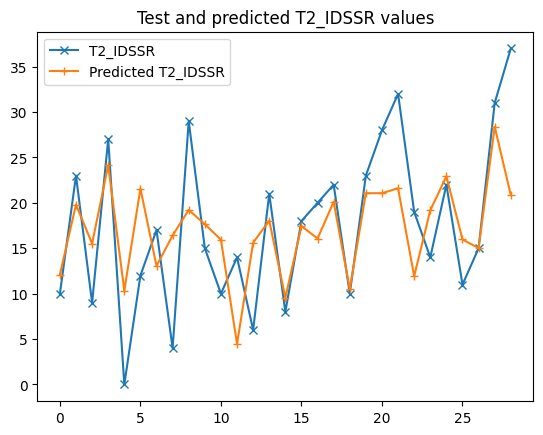

,Gain
SCRN_ITQ_PANAS_negative_affect,6.737011
T0_sd_TST_TIB,8.994873
T0_sd_Cr_of_Grav_Temp_Dec_Hr,13.747444
T0_Z_AmygdalaR_max,14.606239
T0_sd_EyesClosed_Dec_Hr,17.631906
R_delay,19.914490
SCRN_ITQ_MIPIP_neuroticism,21.495661
T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,23.688153


,Weight
therapy_cbti_ct,6
SCRN_ITQ_RPA_dampening,9
T0_Z_AmygdalaR_mean,15
SCRN_ITQ_FSS_score,18
T0_sd_TST_TIB,18
SCRN_ITQ_FIRST_score,23
T0_sd_CSD_Thoughts,24
SCRN_ITQ_PANAS_negative_affect,24


,Cover
SCRN_ITQ_MIPIP_neuroticism,8.610169
T0_sd_Cr_of_Grav_Temp_Dec_Hr,17.777778
T0_Z_AmygdalaR_mean,24.200000
SCRN_ITQ_FSS_score,30.500000
Retrolenticular_part_of_internal_capsule_L,31.482143
R_delay,35.068182
Cingulum_(cingulate_gyrus)_L,36.962963
T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,37.500000


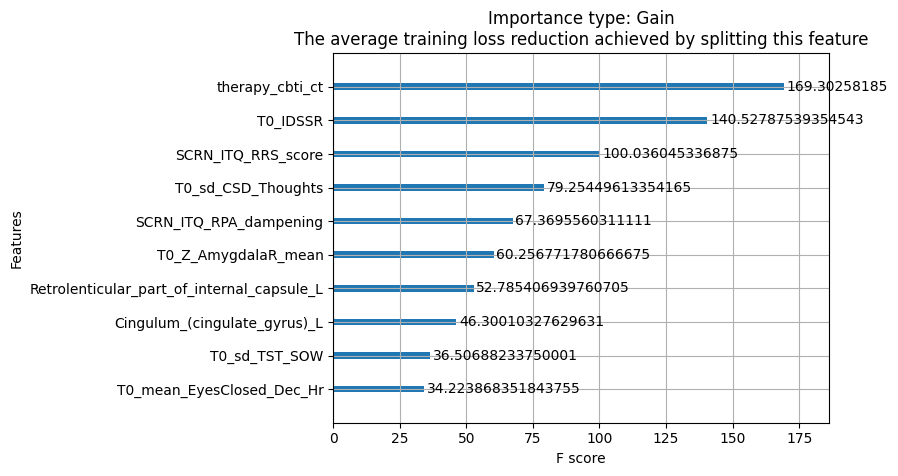

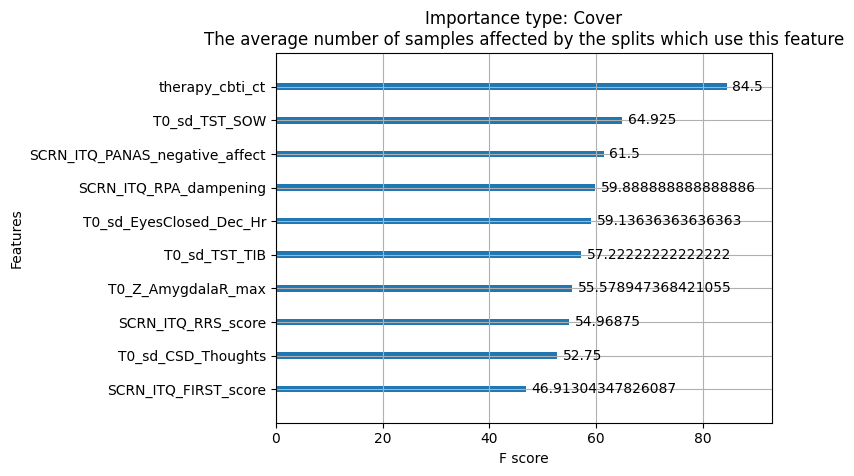

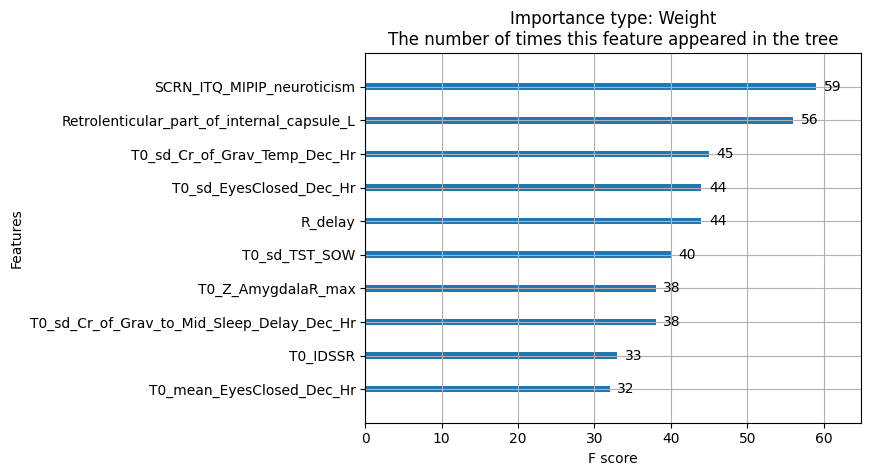

In [ ]:
# rparams =  {'colsample': 0.3725452081172528, 'gamma': 4.251548448492023, 'learning_rate': 0.0025687444688500477, 'max_depth': 5.188414013267926, 'min_child_weight': 0.5994080909262582, 'n_estimators': 970.2658555382554, 'subsample': 0.6743897381706172}; 

plt.style.use('default')
#--------------------------------------------------------------------------------------------------
# XGBoost using XGBRegressor
print('%%%%%%% XGBoost Regression:')
xg_reg = XGBRegressor(objective="reg:squarederror", params=rparams, seed=1)
xg_reg.fit(X_train, y_train)


score = xg_reg.score(X_train, y_train)
print("Training score: ", score )
predictions = xg_reg.predict(X_valid)
print("R2: " + str(r2_score(y_valid, predictions,multioutput='variance_weighted')))
print("RMSE: " + str(np.sqrt(mean_squared_error(y_valid, predictions))))


# TEST VS PREDICTED PLOTS
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="T2_IDSSR", marker='x')
plt.plot(x_ax, predictions, label="Predicted T2_IDSSR",marker='+')
plt.title("Test and predicted T2_IDSSR values")
plt.legend()
plt.show()

# IMPORTANCE PLOTS
xgb.plot_importance(xg_reg,max_num_features = 10, title="Importance type: Gain\nThe average training loss reduction achieved by splitting this feature", importance_type='gain')
xgb.plot_importance(xg_reg,max_num_features = 10, title="Importance type: Cover\nThe average number of samples affected by the splits which use this feature", importance_type='cover')
xgb.plot_importance(xg_reg,max_num_features = 10, title="Importance type: Weight\nThe number of times this feature appeared in the tree", importance_type='weight')


# gain_features = xg_reg.feature_importances_.argsort()
gain_features = xg_reg.get_booster().get_score(importance_type='gain')
# display(gain_features.sort())
####################################################################################
sorted_gain = {}
sorted_keys = sorted(gain_features, key=gain_features.get, reverse=True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_gain[w] = gain_features[w]


gain_df = pd.Series(sorted_gain).to_frame('Gain')

####################################################################################
weight_features = xg_reg.get_booster().get_score(importance_type='weight')

sorted_weight = {}
sorted_keys = sorted(weight_features, key=weight_features.get, reverse=True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_weight[w] = weight_features[w]
####################################################################################
cover_features = xg_reg.get_booster().get_score(importance_type='cover')

sorted_cover = {}
sorted_keys = sorted(cover_features, key=cover_features.get, reverse=True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_cover[w] = cover_features[w]

########################################

gain_df = pd.Series(sorted_gain).to_frame('Gain')
weight_df = pd.Series(sorted_weight).to_frame('Weight')
cover_df = pd.Series(sorted_cover).to_frame('Cover')


display(gain_df.nsmallest(8, columns='Gain')) 
display(weight_df.nsmallest(8, columns='Weight'))
display(cover_df.nsmallest(8, columns='Cover')) 


#### **Permutation Feature Importance**

In [ ]:
perm = PermutationImportance(estimator = xg_reg, random_state=3).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())
display(eli5.show_weights(perm, feature_names = X_valid.columns.tolist(),top=50
                        ))


Weight,Feature
0.2318 ± 0.2181,T0_IDSSR
0.0752 ± 0.0742,SCRN_ITQ_RRS_score
0.0586 ± 0.0427,T0_sd_TST_SOW
0.0541 ± 0.0921,Retrolenticular_part_of_internal_capsule_L
0.0520 ± 0.0762,T0_sd_CSD_Thoughts
0.0471 ± 0.0251,SCRN_ITQ_MIPIP_neuroticism
0.0354 ± 0.0396,Cingulum_(cingulate_gyrus)_L
0.0312 ± 0.0396,SCRN_ITQ_RPA_dampening
0.0302 ± 0.0462,T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr
0.0236 ± 0.0223,T0_sd_EyesClosed_Dec_Hr
